# LDA 모델 맛보기

In [1]:
import re
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
from tqdm import tqdm
%matplotlib inline

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore")

/Users/1112922/miniconda3/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## scikit learn 텍스트 데이터
- sklearn에서 제공하는 텍스트 데이터를 가지고 LDA 모델을 학습해봅니다
- 추천 데이터는 아니지만 LDA를 파악하기 위해서 간단한 실습을 수행합니다

In [2]:
# 학습 데이터 로드

from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
len(documents)

11314

In [3]:
# 문서(document) 예시
documents[1]

"\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism?  No, you need a little leap of faith, Jimmy.  Your logic runs out\nof steam!\n\n\n\n\n\n\n\nJim,\n\nSorry I can't pity you, Jim.  And I'm sorry that you have these feelings of\ndenial about the faith you need to get by.  Oh well, just pretend that it will\nall end happily ever after anyway.  Maybe if you start a new newsgroup,\nalt.atheist.hard, you won't be bummin' so much?\n\n\n\n\n\n\nBye-Bye, Big Jim.  Don't forget your Flintstone's Chewables!  :) \n--\nBake Timmons, III"

In [4]:
# 텍스트 데이터 프리프로세싱

news_df = pd.DataFrame({'document':documents})

# 문서 내 특수문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")

# 문서 내 길이가 3 이하인 단어 제거
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

In [5]:
news_df

,document,clean_doc
0,Well i'm not sure about the story nad it did s...,well sure about story seem biased what disagre...
1,"\n\n\n\n\n\n\nYeah, do you expect people to re...",yeah expect people read actually accept hard a...
2,Although I realize that principle is not one o...,although realize that principle your strongest...
3,Notwithstanding all the legitimate fuss about ...,notwithstanding legitimate fuss about this pro...
4,"Well, I will have to change the scoring on my ...",well will have change scoring playoff pool unf...
...,...,...
11309,"Danny Rubenstein, an Israeli journalist, will ...",danny rubenstein israeli journalist will speak...
11310,\n,
11311,\nI agree. Home runs off Clemens are always m...,agree home runs clemens always memorable kinda...
11312,I used HP DeskJet with Orange Micros Grappler ...,used deskjet with orange micros grappler syste...


In [6]:
# 1차 전처리 document 예시
news_df['clean_doc'][1]

'yeah expect people read actually accept hard atheism need little leap faith jimmy your logic runs steam sorry pity sorry that have these feelings denial about faith need well just pretend that will happily ever after anyway maybe start newsgroup atheist hard bummin much forget your flintstone chewables bake timmons'

In [7]:
# stopwords 제거를 위한 nltk 라이브러리

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/1112922/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# stopwords 예시
stop_words[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [9]:
# 문서 tokenize 이후 stopwords 제거

tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

In [10]:
# 학습에 사용할 최종 데이터
# document를 word로 이루어진 list 형태로 변환
# 추천 데이터의 경우 document = user, word = item의 형태로 구성

tokenized_doc[1]

['yeah',
 'expect',
 'people',
 'read',
 'actually',
 'accept',
 'hard',
 'atheism',
 'need',
 'little',
 'leap',
 'faith',
 'jimmy',
 'logic',
 'runs',
 'steam',
 'sorry',
 'pity',
 'sorry',
 'feelings',
 'denial',
 'faith',
 'need',
 'well',
 'pretend',
 'happily',
 'ever',
 'anyway',
 'maybe',
 'start',
 'newsgroup',
 'atheist',
 'hard',
 'bummin',
 'much',
 'forget',
 'flintstone',
 'chewables',
 'bake',
 'timmons']

In [11]:
# gensim에서 지원하는 dictionary
id2word = corpora.Dictionary(tokenized_doc)

# document를 TF 형태로 변환
corpus = [id2word.doc2bow(text) for text in tokenized_doc]

print(corpus[1])

[(52, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 2), (67, 1), (68, 1), (69, 1), (70, 1), (71, 2), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 2), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 2), (86, 1), (87, 1), (88, 1), (89, 1)]


In [12]:
# 개별 단어는 id의 형태로 변환되어 모델에 사용됨
id2word[52]

'well'

In [13]:
# document 1의 예시
[(id, id2word[id], freq) for id, freq in corpus[1]]

[(52, 'well', 1),
 (55, 'accept', 1),
 (56, 'actually', 1),
 (57, 'anyway', 1),
 (58, 'atheism', 1),
 (59, 'atheist', 1),
 (60, 'bake', 1),
 (61, 'bummin', 1),
 (62, 'chewables', 1),
 (63, 'denial', 1),
 (64, 'ever', 1),
 (65, 'expect', 1),
 (66, 'faith', 2),
 (67, 'feelings', 1),
 (68, 'flintstone', 1),
 (69, 'forget', 1),
 (70, 'happily', 1),
 (71, 'hard', 2),
 (72, 'jimmy', 1),
 (73, 'leap', 1),
 (74, 'little', 1),
 (75, 'logic', 1),
 (76, 'maybe', 1),
 (77, 'much', 1),
 (78, 'need', 2),
 (79, 'newsgroup', 1),
 (80, 'people', 1),
 (81, 'pity', 1),
 (82, 'pretend', 1),
 (83, 'read', 1),
 (84, 'runs', 1),
 (85, 'sorry', 2),
 (86, 'start', 1),
 (87, 'steam', 1),
 (88, 'timmons', 1),
 (89, 'yeah', 1)]

## Gensim LDA 학습
- gensim에서 제공하는 lda 라이브러리
- 모델에 학습하기 위해 필요한 하이퍼 파라미터는 [API 문서](https://radimrehurek.com/gensim/models/ldamodel.html)에서 확인합니다
- multicore를 지원하여 빠르게 학습하는 LdaMulticore 모델을 사용할 수도 있습니다

In [14]:
# lda 모델 학습

topic_num = 20 # 20개의 토픽
ldamodel = gensim.models.ldamodel.LdaModel(corpus,
                                           num_topics = topic_num,
                                           id2word=id2word,
                                           passes=10,
                                           per_word_topics=True)

In [15]:
# 특정 topic의 top 5 단어

topic = 0
topn = 5
for id, prob in ldamodel.get_topic_terms(topic, topn=topn):
    print(ldamodel.id2word[id], prob)

output 0.011324743
entry 0.009872775
number 0.008448817
program 0.008088465
line 0.007243634


In [16]:
# topic별 top 10 단어 출력

topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.011*"output" + 0.010*"entry" + 0.008*"number" + 0.008*"program" + 0.007*"line"')
(1, '0.014*"myers" + 0.010*"stats" + 0.010*"division" + 0.009*"lost" + 0.009*"league"')
(2, '0.011*"people" + 0.009*"would" + 0.008*"said" + 0.007*"time" + 0.007*"know"')
(3, '0.013*"like" + 0.010*"good" + 0.009*"would" + 0.007*"price" + 0.007*"know"')
(4, '0.013*"file" + 0.012*"windows" + 0.009*"available" + 0.009*"software" + 0.009*"files"')
(5, '0.016*"space" + 0.012*"launch" + 0.011*"earth" + 0.009*"satellite" + 0.008*"orbit"')
(6, '0.049*"space" + 0.024*"nasa" + 0.018*"data" + 0.007*"shuttle" + 0.007*"available"')
(7, '0.038*"armenian" + 0.034*"armenians" + 0.023*"turkish" + 0.017*"turkey" + 0.013*"armenia"')
(8, '0.016*"drive" + 0.013*"system" + 0.012*"chip" + 0.011*"scsi" + 0.010*"disk"')
(9, '0.019*"jesus" + 0.011*"christian" + 0.011*"bible" + 0.009*"church" + 0.008*"christians"')
(10, '0.014*"period" + 0.013*"play" + 0.010*"char" + 0.009*"game" + 0.009*"power"')
(11, '0.016*"would" + 0.014*

In [17]:
# 특정 문서의 토픽별 분포
bow = corpus[0]
ldamodel.get_document_topics(bow)

[(2, 0.0791591),
 (7, 0.023212893),
 (9, 0.11625725),
 (11, 0.3372419),
 (15, 0.1756268),
 (17, 0.25700426)]

In [18]:
# 특정 문서의 토픽별 분포
ldamodel.get_document_topics(bow, minimum_probability=0)

[(0, 0.0008212695),
 (1, 0.0008212695),
 (2, 0.07912879),
 (3, 0.0008212695),
 (4, 0.0008212695),
 (5, 0.0008212695),
 (6, 0.0008212695),
 (7, 0.02321326),
 (8, 0.0008212695),
 (9, 0.1162655),
 (10, 0.0008212695),
 (11, 0.33725),
 (12, 0.0008212695),
 (13, 0.0008212695),
 (14, 0.0008212695),
 (15, 0.17563441),
 (16, 0.0008212695),
 (17, 0.2570103),
 (18, 0.0008212695),
 (19, 0.0008212695)]

In [19]:
# 모든 문서에 대해서 토픽을 추출해봅시다

result = []

for i, topic_list in enumerate(ldamodel[corpus]):
    topics = topic_list[0]
    topics = sorted(topics, key=lambda x: (x[1]), reverse=True)
    if len(topics) > 0:
        topic_num, prop_topic = topics[0][0], topics[0][1]
        result.append([i, int(topic_num), round(prop_topic,4)])

topic_table = pd.DataFrame(result, columns = ['doc_id', 'top_topic', 'prop'])

In [20]:
topic_table

,doc_id,top_topic,prop
0,0,11,0.3373
1,1,11,0.4191
2,2,11,0.4788
3,3,8,0.4390
4,4,9,0.3707
...,...,...,...
11309,11309,19,0.2922
11310,11310,0,0.0500
11311,11311,15,0.6793
11312,11312,8,0.7065


In [21]:
# Perplexity 계산, Perplexity가 낮을수록 좋은 모델을 의미함
print('Perplexity: ', ldamodel.log_perplexity(corpus))

Perplexity:  -10.75247468183706


In [22]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.269703  0.044067       1        1  17.495711
2     -0.231153  0.100833       2        1  16.655941
4     -0.216684 -0.139406       3        1  11.121779
3     -0.241016  0.046510       4        1   8.254036
0     -0.158263 -0.105881       5        1   7.685138
8     -0.176228 -0.097948       6        1   5.994000
19    -0.012565 -0.119049       7        1   5.840615
9     -0.146214  0.077071       8        1   5.432955
15    -0.159973  0.203162       9        1   4.450920
10     0.120705  0.217590      10        1   2.503476
5      0.067610 -0.076423      11        1   2.406411
17     0.095182 -0.045135      12        1   2.237776
14     0.109877 -0.124140      13        1   1.933406
6      0.113927 -0.186760      14        1   1.903525
7      0.141584  0.005337      15        1   1.771841
13     0.117776 -0.014719      16        1   1.453208
1      0.193156  0.137572      17        1   1.084452
16     0.180837  0.021600      18        1   1.016844
18     0.229753  0.032973      19        1   0.494098
12     0.241392  0.022744      20        1   0.263867, topic_info=         Term         Freq        Total Category  logprob  loglift
1883    space  1288.000000  1288.000000  Default  30.0000  30.0000
80     people  4411.000000  4411.000000  Default  29.0000  29.0000
2170   window  1017.000000  1017.000000  Default  28.0000  28.0000
282      file  1942.000000  1942.000000  Default  27.0000  27.0000
130     would  6492.000000  6492.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
2873    shift    10.614472    82.770133  Topic20  -5.4698   3.8836
472   battery    10.331117    94.472714  Topic20  -5.4968   3.7243
3364   lights     9.255928    53.484594  Topic20  -5.6067   4.1834
8016  kitchen     8.074213    24.840019  Topic20  -5.7433   4.8137
9535     prof     7.986431    37.910561  Topic20  -5.7542   4.3800

[1296 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
7058       1  0.929429     absolute
7058       8  0.065917     absolute
6749       6  0.992392  accelerator
519        1  0.026400       access
519        2  0.043371       access
...      ...       ...          ...
2205      10  0.057916         york
2205      15  0.083656         york
2205      17  0.215574         york
23553      2  0.990933      zionist
7406       4  0.980261         zoom

[3383 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 3, 5, 4, 1, 9, 20, 10, 16, 11, 6, 18, 15, 7, 8, 14, 2, 17, 19, 13])

# 커머스 데이터로 LDA 추천 모델 만들기
- 사용자 = 문서, 단어 = 구매한 아이템.
- 각 사용자는 n개 토픽의 분포로 표현되고, 각 토픽은 아이템의 분포로 표현됩니다.
- 사용자가 특정 토픽에 대한 비율이 높다면, 그 사용자에게 해당 토픽의 비율이 높은 아이템을 추천해줍니다.

In [23]:
file_path = '../data/online_retail.csv'
parse_date = lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M')
retail_df = pd.read_csv(file_path, encoding="utf-8", parse_dates = ['InvoiceDate'], date_parser = parse_date)

In [24]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [25]:
stock_to_description = {row['StockCode']: row['Description'] for _, row in retail_df.iterrows()}

In [26]:
# 사용자 아이디가 없는 데이터 제외
# quantity가 음수인 데이터 제외

cleaned_retail_df = retail_df[~(retail_df['CustomerID'].isnull()) & (retail_df['Quantity'] > 0)]

In [27]:
# 데이터 전처리

cleaned_retail_df['CustomerID'] = cleaned_retail_df.CustomerID.astype(int)
cleaned_retail_df['StockCode'] = cleaned_retail_df['StockCode'].astype('str')
cleaned_retail_df = cleaned_retail_df[['InvoiceNo', 'StockCode', 'Quantity', 'CustomerID', 'InvoiceDate']] 
cleaned_retail_df['ym'] = cleaned_retail_df['InvoiceDate'].apply(lambda x: str(x)[:7])

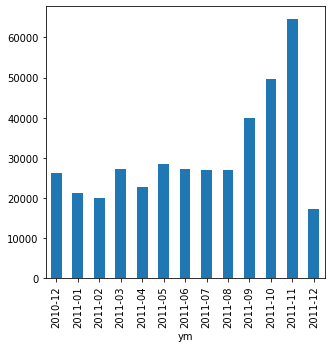

In [28]:
# 전체 기간 데이터 확인

cleaned_retail_df.groupby(['ym'])['StockCode'].count().plot.bar(figsize=(5,5))

In [29]:
# 2011-09 ~ 2011-11 데이터를 train 데이터로 사용하고, 2011-12 데이터의 test 데이터로 사용합니다

cleaned_retail_df['ym'] = cleaned_retail_df['InvoiceDate'].apply(lambda x: str(x)[:7])
train_df = cleaned_retail_df[(cleaned_retail_df['ym'] >= '2011-09') & (cleaned_retail_df['ym'] <= '2011-11')]
test_df = cleaned_retail_df[cleaned_retail_df['ym'] == '2011-12']

In [30]:
# 사용자 별로 groupby 하여 문서의 형태로 만들어줍니다

train_groupby = train_df.groupby(['CustomerID'])

doc_list = []

for user_id, user_df in train_groupby:
    document = user_df['StockCode'].values.tolist()
    doc_list.append(document)

In [31]:
# 학습 데이터 샘플
doc_list[100]

['22993',
 '16045',
 '22398',
 '22608',
 '22610',
 '21558',
 '16008',
 '23379',
 '23392',
 '23559',
 '90087',
 '23388',
 '23389',
 '21559',
 '22352',
 '35964',
 '22579',
 '21015',
 '21014',
 '22336',
 '23483',
 '23540',
 '23542',
 'POST',
 '22326',
 '21580',
 '22327',
 'POST']

In [32]:
# gensim에서 지원하는 dictionary
id2word = corpora.Dictionary(doc_list)

# 문서를 TF의 형태로 변환
corpus = [id2word.doc2bow(doc) for doc in doc_list]

print(corpus[100])

[(49, 2), (67, 1), (139, 1), (148, 1), (329, 1), (342, 1), (343, 1), (354, 1), (433, 1), (434, 1), (501, 1), (741, 1), (757, 1), (774, 1), (800, 1), (1035, 1), (1081, 1), (1192, 1), (1213, 1), (1403, 1), (1404, 1), (1405, 1), (1406, 1), (1407, 1), (1408, 1), (1409, 1), (1410, 1)]


In [33]:
import gensim
topic_num = 20 #20개의 토픽, k=20
ldamodel = gensim.models.ldamodel.LdaModel(corpus,
                                           num_topics = topic_num,
                                           id2word=id2word,
                                           passes=10)

In [34]:
# 20개의 토픽별 Top N 아이템 분포 확인

topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.013*"23263" + 0.011*"23266" + 0.010*"23265" + 0.009*"23264" + 0.009*"23275"')
(1, '0.021*"22197" + 0.019*"23084" + 0.016*"23177" + 0.013*"23194" + 0.012*"23176"')
(2, '0.032*"84946" + 0.029*"22791" + 0.029*"84947" + 0.028*"22577" + 0.027*"22578"')
(3, '0.010*"22551" + 0.010*"22554" + 0.008*"22086" + 0.008*"22555" + 0.008*"21889"')
(4, '0.014*"22909" + 0.014*"22910" + 0.013*"22086" + 0.012*"22952" + 0.011*"22734"')
(5, '0.017*"POST" + 0.015*"22629" + 0.014*"22630" + 0.010*"22326" + 0.010*"23084"')
(6, '0.025*"21669" + 0.022*"23032" + 0.021*"21668" + 0.021*"21670" + 0.020*"84879"')
(7, '0.022*"20727" + 0.017*"22383" + 0.016*"20725" + 0.015*"23209" + 0.014*"22382"')
(8, '0.019*"85123A" + 0.018*"82494L" + 0.015*"22469" + 0.015*"23322" + 0.015*"82482"')
(9, '0.016*"20679" + 0.015*"15056BL" + 0.015*"22738" + 0.013*"22739" + 0.013*"M"')
(10, '0.058*"23355" + 0.044*"22112" + 0.040*"22114" + 0.034*"22111" + 0.033*"23356"')
(11, '0.016*"21034" + 0.009*"21619" + 0.009*"85034C" + 0.008*"233

In [35]:
# 20개의 토픽별 Top N 아이템 분포 확인

for i in range(20):
    recommend = ldamodel.show_topic(topicid=i, topn=5)
    print(i, [stock_to_description[item] for item, score in recommend])

0 ['SET OF 3 WOODEN HEART DECORATIONS', 'SET OF 3 WOODEN STOCKING DECORATION', 'SET OF 3 WOODEN TREE DECORATIONS', 'SET OF 3 WOODEN SLEIGH DECORATIONS', 'SET OF 3 HANGING OWLS OLLIE BEAK']
1 ['POPCORN HOLDER', 'RABBIT NIGHT LIGHT', 'TREASURE ISLAND BOOK BOX', 'GYMKHANA TREASURE BOOK BOX', 'ABC TREASURE BOOK BOX ']
2 ['ANTIQUE SILVER T-LIGHT GLASS', 'T-LIGHT GLASS FLUTED ANTIQUE', 'ANTIQUE SILVER TEA GLASS ENGRAVED', 'WOODEN HEART CHRISTMAS SCANDINAVIAN', 'WOODEN STAR CHRISTMAS SCANDINAVIAN']
3 ['PLASTERS IN TIN SPACEBOY', 'PLASTERS IN TIN WOODLAND ANIMALS', "PAPER CHAIN KIT 50'S CHRISTMAS ", 'PLASTERS IN TIN STRONGMAN', 'WOODEN BOX OF DOMINOES']
4 ['SET OF 20 VINTAGE CHRISTMAS NAPKINS', 'PAPER CHAIN KIT VINTAGE CHRISTMAS', "PAPER CHAIN KIT 50'S CHRISTMAS ", '60 CAKE CASES VINTAGE CHRISTMAS', 'SET OF 6 RIBBONS VINTAGE CHRISTMAS']
5 ['POSTAGE', 'SPACEBOY LUNCH BOX ', 'DOLLY GIRL LUNCH BOX', 'ROUND SNACK BOXES SET OF4 WOODLAND ', 'RABBIT NIGHT LIGHT']
6 ['BLUE STRIPE CERAMIC DRAWER KNOB',

In [36]:
# 유저의 토픽 분포를 구해봅시다

user_topic_dict = {}

for user_id, user_df in train_groupby:
    document = user_df['StockCode'].values.tolist()
    user_topic_dict[user_id] = ldamodel.get_document_topics(id2word.doc2bow(document), minimum_probability=0.0)

In [37]:
user_id = 12682
user_topic_dict[user_id]

[(0, 0.00035465768),
 (1, 0.00035465768),
 (2, 0.00035465768),
 (3, 0.00035465768),
 (4, 0.00035465768),
 (5, 0.5483172),
 (6, 0.00035465768),
 (7, 0.00035465768),
 (8, 0.00035465768),
 (9, 0.1300236),
 (10, 0.00035465768),
 (11, 0.00035465768),
 (12, 0.00035465768),
 (13, 0.00035465768),
 (14, 0.00035465768),
 (15, 0.029265743),
 (16, 0.00035465768),
 (17, 0.27219823),
 (18, 0.014875428),
 (19, 0.00035465768)]

## LDA로 유저에게 추천

### 유저 토픽 가운데 확률이 높은 topic을 이용한 추천

In [38]:
# 유저의 토픽 분포를 확인하고 가장 확률이 높은 토픽을 선택합니다.
# 해당 토픽에 속한 Top N 아이템을 추천합니다.
# example: user: 12682, n: 20

topn = 20
user_id = 12682
user_topics = user_topic_dict[user_id]
user_topics = sorted(user_topics, key=lambda x: (x[1]), reverse=True)
user_topic = user_topics[0][0]
recommend = ldamodel.show_topic(topicid=user_topic, topn=topn)
recommend = [item for item, score in recommend]
recommend

['POST',
 '22629',
 '22630',
 '22326',
 '23084',
 '22029',
 '23389',
 '22328',
 '21731',
 '22659',
 '23309',
 '23480',
 '23346',
 '23390',
 '22983',
 '23345',
 '22382',
 '22712',
 '23290',
 '23292']

In [39]:
user_topic

5

In [40]:
# 실제 유저가 test 데이터에서 선호한(구매한) 아이템

relevant = test_df[test_df['CustomerID'] == user_id]['StockCode'].unique()
list(relevant)

['20750',
 '21931',
 '85099B',
 '22423',
 '21242',
 '21243',
 '21239',
 '21240',
 '23040',
 '22596',
 '22456',
 '48185',
 '21770',
 '21977',
 '21212',
 '84375',
 '23163',
 '84378',
 '23020',
 '22966',
 '23084',
 '22556',
 '22551',
 '22555',
 '47566',
 '23192',
 '22139',
 '22138',
 '22467',
 'POST']

In [41]:
def get_precision(relevant, recommend):
    
    _intersection = set(recommend).intersection(set(relevant))
    return len(_intersection) / len(recommend)

def get_recall(relevant, recommend):
    
    _intersection = set(recommend).intersection(set(relevant))
    return len(_intersection) / len(relevant)

In [42]:
# precision
print(get_precision(relevant, recommend))

# recall
print(get_recall(relevant, recommend))

0.1
0.06666666666666667


### Top N 추천 성능 평가

In [43]:
# 유저별로 추천하여 전체 성능을 구해봅시다

train_user_ids = train_df['CustomerID'].unique()
test_user_ids = test_df['CustomerID'].unique()
topn = 20

default_recommend = list(train_df.groupby('StockCode')['Quantity'].count().sort_values(ascending=False)[:topn].index)

precisions = []
recalls = []

for user_id in test_user_ids:

    if user_id in train_user_ids:        
        user_topics = user_topic_dict[user_id]
        user_topics = sorted(user_topics, key=lambda x: (x[1]), reverse=True)
        user_topic = user_topics[0][0]
        recommend = [item for item, score in ldamodel.show_topic(topicid=user_topic, topn=topn)]        
    else:
        recommend = default_recommend
    
    relevant = test_df[test_df['CustomerID'] == user_id]['StockCode'].unique()
    precisions.append(get_precision(relevant, recommend))
    recalls.append(get_recall(relevant, recommend))
    
print('precision@k:', np.mean(np.asarray(precisions)))
print('recall@k:', np.mean(np.asarray(recalls)))

precision@k: 0.10552845528455286
recall@k: 0.12661685968667544


In [44]:
len(train_user_ids)

2852